In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import init
from tabulate import tabulate
import csv
from focal_Loss import *
from utility import *
from torch.utils.tensorboard import SummaryWriter  


# Read dataset

In [3]:
data_name = "SC1000"
# data_name = "CFL30"

data_path = "DataSet"+data_name+"/"
split = [0.70,0.15,0.15]

dataSet = load_data(data_path)

data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device)
if device == torch.device("cuda"):
#     torch.cuda.empty_cache()
    data_train_gpu = []
    for i in range(len(data_train)):
        inputs, labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_train[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_train_gpu.append([inputs,labels,A])
    data_valide_gpu = []
    for i in range(len(data_validation)):
        inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_validation[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_valide_gpu.append([inputs,labels,A])
        
    data_test_gpu = []
    for i in range(len(data_test)):
        inputs, labels = torch.from_numpy(data_test[i]['X']).float(),torch.from_numpy(data_test[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_test[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_test_gpu.append([inputs,labels,A])

cuda


# GCN

In [4]:
class simpleMLP(nn.Module):
    def __init__(self, input_size, out_size,activate = nn.ReLU()):
        super(simpleMLP, self).__init__()
        self.linear = nn.Linear(input_size, out_size)
        self.activate = activate
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activate(x)
        return x
    
class GNN(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(GNN,self).__init__()
        self.mlp = nn.ModuleList(
            [simpleMLP(input_size, hidden_size)]+[simpleMLP(hidden_size, hidden_size) for i in range(nb_MLP - 1)]   
        )
    
    def forward(self, x, A):
        for mlp_module in self.mlp:
            x = mlp_module(x)
            x = A @ x
        return x
    
# class GNN(nn.Module):
#     def __init__(self, input_size,hidden_size,nb_MLP):
#         super(GNN,self).__init__()
#         self.input_mlp = simpleMLP(input_size, hidden_size)
#         self.mlp = nn.ModuleList(
#             [simpleMLP(hidden_size, hidden_size) for i in range(nb_MLP - 1)]   
#         )
    
#     def forward(self, x, A):
#         x = self.input_mlp(x)
# #         x = A @ x
#         for mlp_module in self.mlp:
#             x = mlp_module(x)
# #             x = A @ x
#         return x
    
class VariablePredictor(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictor,self).__init__()
        self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer = simpleMLP(hidden_size,1,nn.Sigmoid())    
    
    def forward(self,x,A):
        x = self.GNN(x,A)
        return self.outlayer(x)




class VariablePredictor_OnlyOutLayer(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictor_OnlyOutLayer,self).__init__()
#         self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer = simpleMLP(hidden_size,1,nn.Sigmoid())    
    
    def forward(self,x,A):
#         x = self.GNN(x,A)
        return self.outlayer(x)        

## Train


In [5]:
def train_step(model, x, y,A, optimizer,criterion):
    optimizer.zero_grad()
    output = model(x,A)[:len(y)].squeeze(dim=-1)
#     print("output",output)
    loss =criterion(output,y)
#     print("loss",loss)
    loss.backward()
    optimizer.step()
    
    return loss, output


def valide(model,criterion,data_validation,proportion = 0.7):
        vloss = []
        accuracy_value = []
        accuracy_instance = []
        
        accuracy_one = []
        accuracy_one_predict = []
        nb_predict_one = []
        nb_one = []
        
        accuracy_zero = []
        accuracy_zero_predict = []
        nb_zero = []
        nb_predict_zero = []
        
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        accuracy_fixe = []
        
        data_size = len(data_validation)
        for i in range(data_size):
            if device == torch.device("cuda"):
                inputs, labels = data_validation[i][0],data_validation[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =data_validation[i][2]# torch.from_numpy(data_train[i]['A']).float()
            else:
                inputs, labels =torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =torch.from_numpy(data_train[i]['A']).float()
            predictions = model(inputs,A)[:len(labels)].squeeze(dim=-1)
            loss =criterion(predictions,labels)
            A = A.cpu()
            labels = labels.cpu()
            predictions = predictions.cpu()
            
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_zero_total = (len(labels) - nb_one_total)
            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == labels,1,0)
            vloss.append(loss.cpu().detach().numpy())
            accuracy_value.append(is_equal.cpu().sum().detach().numpy()/
                           len(labels))
            accuracy_instance.append(int(accuracy_value[-1]==1))
            #accuracy proportion
            predictions_abs =  np.abs(0.5 - predictions.detach().numpy())
            thresholds = abs(np.sort(-predictions_abs))[int(proportion * len(predictions.cpu().detach().numpy()))- 1]
#             thresholds_low = np.sort(predictions_abs)[int(proportion_low * nb_zero_total]
#             thresholds_up = abs(np.sort(-predictions_abs))[int(proportion_up * nb_one_total)]
            
            #accuracy for differents labels(0 or 1)
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_one = 0
            nb_correct_zero = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_equal):
                if labels[j] == 1:
                    nb_correct_one += v
                else:
                    nb_correct_zero += v

                if predictions_abs[j] >= thresholds:             
                    if labels[j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1

#                 if predictions_abs[j] <= thresholds_low:
#                     if labels[j] == 0:
#                         nb_correct_fixe_zero += v
#                     nb_zero_to_fixe += 1
#                 if predictions_abs[j] >= thresholds_up:
#                     if labels[j] == 1:
#                         nb_correct_fixe_one += v
#                     nb_one_to_fixe += 1
                    
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_one_predict = torch.sum(torch.where(y_hat == 1,1,0))
            accuracy_one.append((nb_correct_one/nb_one_total))
            accuracy_one_predict.append((nb_correct_one/nb_one_predict) if nb_one_predict > 0 else 0)
            nb_predict_one.append(nb_one_predict)
            nb_one.append(nb_one_total)
            
            nb_zero_predict = (len(labels) - nb_one_predict)
            accuracy_zero.append((nb_correct_zero/nb_zero_total))
            accuracy_zero_predict.append((nb_correct_zero/nb_zero_predict) if nb_zero_predict > 0 else 0)
            nb_predict_zero.append(nb_zero_predict)
            nb_zero.append(nb_zero_total)
            
            accuracy_fixe.append((nb_correct_fixe_one+nb_correct_fixe_zero)/(nb_one_fixe+nb_zero_fixe))
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
            
        #     print(nb_correct_fixe.cpu(),nb_var_fixe)
        #         print(labels,"\n",predictions)
        #         print(labels[0:10],y_hat[0:10])
        msg = ("Loss = %f,Accuracy_value = %f,Accuracy_instance = %f\n"\
              %(np.mean(vloss),np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance)))
        msg +=("Label_One_Predict_One = %f,Predict_One_Label_One = %f,Nombre_Predict_One = %f,Nombre_One_Mean = %f\n"\
              %(np.mean(accuracy_one),np.mean(accuracy_one_predict),np.mean(nb_predict_one),np.mean(nb_one)))
        msg +=("Label_Zero_Predict_Zero = %f,Label_Zero_Predict_Zero = %f,Nombre_Predict_Zero = %f,Nombre_Zero_Mean = %f\n"\
              %(np.mean(accuracy_zero),np.mean(accuracy_zero_predict),np.mean(nb_predict_zero),np.mean(nb_zero)))
        msg +=("Accuracy_fixe_mean = %f,Accuracy_fixe_one = %f,Accuracy_fixe_zero = %f\n"\
              %(np.mean(accuracy_fixe),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)))
        print(msg)
        return msg,np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)

In [43]:
def train(net,criterion,data_valide,proportion,writer,EPOCHS=500,do_valide = True,do_log = True,epochs_continue = 0):
    aux= torch.Tensor([0.5]).to(device)
    for epoch in tqdm(range(epochs_continue,epochs_continue+EPOCHS)):
        #validation
        if do_valide and epoch % 50 == 0:
            v = valide(net,criterion,data_valide,proportion)
            if do_log:
                writer.add_scalar('Accuracy_fixe_one ', v[3], epoch)
                writer.add_scalar('Accuracy_fixe_zero ', v[4], epoch)
        #train
        data_size = len(data_train)
        log = []
        for i in range(data_size):
            if device == torch.device("cuda"):
                train_inputs, train_labels = data_train_gpu[i][0],data_train_gpu[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =data_train_gpu[i][2]# torch.from_numpy(data_train[i]['A']).float()
            else:
                train_inputs, train_labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A = torch.from_numpy(data_train[i]['A']).float()    
            loss, predictions = train_step(net,train_inputs,train_labels,A,optm, criterion)

            gradient_norm = 0
            for p in net.parameters():
                param_norm = p.grad.detach().data.norm(2)
                gradient_norm += param_norm.item() ** 2
            gradient_norm = gradient_norm ** 0.5

            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == train_labels,1,0)
            acc = is_equal.cpu().sum().detach().numpy()/len(train_labels)
    #         is_correct_predit_one = 0
    #         for i,v in enumerate(is_equal):
    #             if v == 1 and train_labels[i]==1:
    #                 is_correct_predit_one
    #         if is_correct_predit_one != 0:
    #             print(is_correct_predit_one)
            log.append([loss.cpu().detach().numpy(),acc,gradient_norm])
        log = np.array(log).T
        if do_log:
            writer.add_scalar('Loss', np.mean(log[0]), epoch)
            writer.add_scalar('Accuracy', np.mean(log[1]), epoch)
            writer.add_scalar('Gradient_norm', np.mean(log[2]), epoch)


In [15]:
print(device)


cuda


In [ ]:
nb_mlp = 1
EPOCHS = 300
proportion = 0.8
H = 50
info_valide = []
gamma = 0.5
alpha = 0.25
for nb_mlp in [1]:
    criterion = nn.BCELoss()
#     criterion = FocalLoss(gamma=gamma,alpha = alpha)
    if criterion.__str__()=="BCELoss()":
        train_name = data_name+"_BCE_"+nb_mlp.__str__()+"MLP"+H.__str__()+"TailleH"
    elif criterion.__str__()=="FocalLoss()":
        train_name = data_name+"_FL_"+gamma.__str__()+"Gamma_"+alpha.__str__()+"Alpha_"+nb_mlp.__str__()+"MLP"+H.__str__()+"TailleH"

    writer = SummaryWriter('./logs/'+train_name+"/")
    net = VariablePredictor(24,H,nb_mlp)
    net.to(device)
    optm = Adam(net.parameters(), lr = 0.01)
    train(net,criterion,data_valide_gpu,proportion,writer,EPOCHS=EPOCHS,do_valide = True,do_log = True)
    model_path = "model/"+train_name
    torch.save(net.state_dict(),model_path)
    msg=valide(net,criterion,data_test_gpu,proportion = proportion)
    info_valide.append(msg[1:])
    with open('./logs/'+train_name+"/valide_log.txt", "w") as txtfile:
        print("{}".format(msg), file=txtfile)

    

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Loss = 0.382553,Accuracy_value = 0.971341,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.000000,Predict_One_Label_One = 0.000000,Nombre_Predict_One = 0.000000,Nombre_One_Mean = 23.333333
Label_Zero_Predict_Zero = 1.000000,Label_Zero_Predict_Zero = 0.971341,Nombre_Predict_Zero = 917.777778,Nombre_Zero_Mean = 894.444444
Accuracy_fixe_mean = 0.977958,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.977958



 17%|█████████████▌                                                                   | 50/300 [00:24<01:55,  2.17it/s]

Loss = 0.019171,Accuracy_value = 0.993537,Accuracy_instance = 0.355556
Label_One_Predict_One = 0.871022,Predict_One_Label_One = 0.869525,Nombre_Predict_One = 23.466667,Nombre_One_Mean = 23.333333
Label_Zero_Predict_Zero = 0.996629,Label_Zero_Predict_Zero = 0.996712,Nombre_Predict_Zero = 894.311111,Nombre_Zero_Mean = 894.444444
Accuracy_fixe_mean = 1.000000,Accuracy_fixe_one = 0.066667,Accuracy_fixe_zero = 1.000000



 33%|██████████████████████████▋                                                     | 100/300 [00:47<01:23,  2.40it/s]

Loss = 0.018890,Accuracy_value = 0.993583,Accuracy_instance = 0.355556
Label_One_Predict_One = 0.871022,Predict_One_Label_One = 0.871176,Nombre_Predict_One = 23.422222,Nombre_One_Mean = 23.333333
Label_Zero_Predict_Zero = 0.996676,Label_Zero_Predict_Zero = 0.996712,Nombre_Predict_Zero = 894.355556,Nombre_Zero_Mean = 894.444444
Accuracy_fixe_mean = 1.000000,Accuracy_fixe_one = 0.044444,Accuracy_fixe_zero = 1.000000



 50%|████████████████████████████████████████                                        | 150/300 [01:09<01:02,  2.40it/s]

Loss = 0.018644,Accuracy_value = 0.993654,Accuracy_instance = 0.400000
Label_One_Predict_One = 0.872370,Predict_One_Label_One = 0.870629,Nombre_Predict_One = 23.488889,Nombre_One_Mean = 23.333333
Label_Zero_Predict_Zero = 0.996657,Label_Zero_Predict_Zero = 0.996807,Nombre_Predict_Zero = 894.288889,Nombre_Zero_Mean = 894.444444
Accuracy_fixe_mean = 1.000000,Accuracy_fixe_one = 0.044444,Accuracy_fixe_zero = 1.000000



 65%|████████████████████████████████████████████████████                            | 195/300 [01:29<00:43,  2.39it/s]

In [ ]:
nb_mlp = 1
EPOCHS = 1000
proportion = 0.8
H = 50
info_valide = []
gamma = 0.5
alpha = 0.25
for H in [10,50,100]:
    criterion = nn.BCELoss()
#     criterion = FocalLoss(gamma=gamma,alpha = alpha)
    if criterion.__str__()=="BCELoss()":
        train_name = data_name+"_BCE_"+nb_mlp.__str__()+"MLP"+H.__str__()+"TailleH"
    elif criterion.__str__()=="FocalLoss()":
        train_name = data_name+"_FL_"+gamma.__str__()+"Gamma_"+alpha.__str__()+"Alpha_"+nb_mlp.__str__()+"MLP"+H.__str__()+"TailleH"

    writer = SummaryWriter('./logs/'+train_name+"/")
    net = VariablePredictor(24,H,nb_mlp)
    net.to(device)
    optm = Adam(net.parameters(), lr = 0.0001)
    train(net,criterion,data_valide_gpu,proportion,writer,EPOCHS=EPOCHS,do_valide = True,do_log = True)
    model_path = "model/"+train_name
    torch.save(net.state_dict(),model_path)
    msg=valide(net,criterion,data_test_gpu,proportion = proportion)
    info_valide.append(msg[1:])
    with open('./logs/'+train_name+"/valide_log.txt", "w") as txtfile:
        print("{}".format(msg), file=txtfile)


In [10]:
m=valide(model,nn.BCELoss(),data_test_gpu,proportion = 0.9)

Loss = 3.034445,Accuracy_value = 0.969656,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.000000,Predict_One_Label_One = 0.000000,Nombre_Predict_One = 0.000000,Nombre_One_Mean = 23.955556
Label_Zero_Predict_Zero = 1.000000,Label_Zero_Predict_Zero = 0.969656,Nombre_Predict_Zero = 904.444444,Nombre_Zero_Mean = 880.488889
Accuracy_fixe_mean = 0.969656,Accuracy_fixe_one = 0.000000,Accuracy_fixe_zero = 0.969656



## Test

In [35]:
# nb_mlp = 1
# net = VariablePredictor(24,50,nb_mlp)
# net.to(device)
# data_name = "SC100"

# model_path = "model/"+data_name+"_MLP"+nb_mlp.__str__()+"Gamma"+gam.__str__()
model_path = "model/"+train_name
torch.save(net.state_dict(),model_path)


In [ ]:
# model_path = "model/SC1000_MLP3_NoA"
model_path = "model/CFL30_MLP3_NoA"
torch.save(net.state_dict(),model_path)

In [8]:
train_name = data_name+"_FL_"+"3Gamma_"+alpha.__str__()+"Alpha_"+"1MLP"
model_path = "model/CFL30_FL_1Gamma_0.1Alpha_3MLP"
model = VariablePredictor(24,50,3).to(device)
model.load_state_dict(torch.load(model_path))
valide(model,criterion,data_test_gpu,proportion = 0.8)

NameError: name 'alpha' is not defined

# Analyse


In [71]:
def predict(model,data_validation):
        predictions_values = []
        is_predict_correct = []
        data_size = len(data_validation)
        y_hats = []
        labels = []
        for i in range(data_size):
            if data_validation[0][0].device == "cpu":
                inputs, label = torch.from_numpy(data_validation[i]['X']).float(),\
                                torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
                A = torch.from_numpy(data_validation[i]['A']).float()
                inputs = inputs.to(device)
                label = label.to(device)
                A = A.to(device)
            else:
                inputs, label = data_validation[i][0],data_validation[i][1]
                A =data_validation[i][2]
                
            predictions = model(inputs,A)[:len(label)].squeeze(dim=-1)
            label = label.cpu()
            predictions = predictions.cpu()
            predictions_values.append(predictions)

            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == label,1,0)
            is_predict_correct.append(is_equal)
            y_hats.append(y_hat)
            labels.append(label)
        return predictions_values,labels,y_hats,is_predict_correct

def fixe_proportionally(predictions_values,labels,y_hat,is_predict_correct,proportion = 0.7): 
        hist_nb_one_fixe = []
        hist_nb_zero_fixe = []
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        
        data_size = len(predictions_values)
        for i in range(data_size):
            problem_size = len(y_hat[i])
            nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
            nb_zero_total = (problem_size - nb_one_total)
            aux= torch.Tensor([0.5])
            predictions_norm =  np.abs(0.5 - predictions_values[i].detach().numpy())
            thresholds = abs(np.sort(-predictions_norm))[int(proportion * problem_size)- 1]
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_predict_correct[i]):
                if predictions_norm[j] >= thresholds:             
                    if labels[i][j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[i][j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1
            hist_nb_one_fixe.append(nb_one_fixe)
            hist_nb_zero_fixe.append(nb_zero_fixe)
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
        return np.mean(accuracy_fixe_one),np.mean(hist_nb_one_fixe),np.mean(accuracy_fixe_zero),np.mean(hist_nb_zero_fixe)
    
def fixe_one_epsilon(predictions_values,y_hats,labels,e = 0.01):
    nbs_fixe = []
    accs_fixe = []
    props = []
    data_size = len(data_validation)
    thresholds = 1 - e
    for i in range(data_size):
        problem_size = len(labels[i])
        nb_fixe = 0
        nb_correct_fixe = 0
        nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
        for j in range(problem_size):
            if predictions[i][j] >= thresholds:  
                nb_fixe += 1
                if y_hats[i][j] and labels[i][j]:
                    nb_correct_fixe += 1
        nbs_fixe.append(nb_fixe)
        accs_fixe.append(nb_correct_fixe/nb_fixe if nb_fixe > 0 else 0)        
        props.append(nb_correct_fixe/nb_one_total)
    return np.mean(accs_fixe),np.mean(nbs_fixe),np.mean(props)

def get_cost_effective(data_instance):
    features = data_instance[0]
    labels = data_instance[1]
    size = len(labels)
    A=data_instance[2] 
    return [float(features[i][0]/sum(torch.where(A[i]==0,0,1))) for i in range(size)]



    

In [115]:
_ = valide(model,criterion,data_test_gpu,proportion = 1)

Loss = 0.124151,Accuracy_value = 0.994478,Accuracy_instance = 0.422222
Label_One_Predict_One = 0.910292,Predict_One_Label_One = 0.913030,Nombre_Predict_One = 23.933333,Nombre_One_Mean = 23.955556
Label_Zero_Predict_Zero = 0.997162,Label_Zero_Predict_Zero = 0.997095,Nombre_Predict_Zero = 880.511111,Nombre_Zero_Mean = 880.488889
Accuracy_fixe_mean = 0.994478,Accuracy_fixe_one = 0.913030,Accuracy_fixe_zero = 0.997095



In [125]:
prediction_mean = np.zeros((500))
data_size = len(data_test_gpu)
for i in tqdm(range(data_size)):
    cost_effective = get_cost_effective(data_test_gpu[i])
    aux_dict = {}
    for j,v in enumerate(cost_effective):
        aux_dict[j] = v
    aux_dict = sorted(aux_dict.items(), key = lambda kv:(kv[1], kv[0]))
    inputs, label = data_test_gpu[i][0],data_test_gpu[i][1]
    A =data_test_gpu[i][2]

    predictions = model(inputs,A)[:len(label)].squeeze(dim=-1)
    label = label.cpu()
    predictions = predictions.cpu()

    cost_effective_reorder = []
    predictions_reorder=[]
    for idx in range(len(prediction_mean)):
        prediction_mean[idx]+=float(predictions[aux_dict[idx][0]])


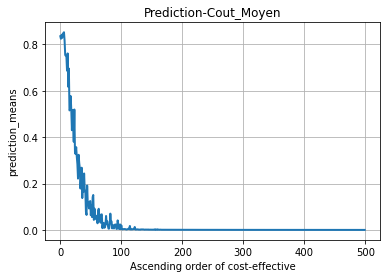

In [129]:
prediction_means = prediction_mean/data_size
fig, ax = plt.subplots()
# acc_one,= ax.plot(range(len(cost_effective_reorder)),cost_effective_reorder, linewidth=2.0,label=r'')
nb_one,= ax.plot(range(len(prediction_means)),prediction_means , linewidth=2.0)
plt.title("Prediction-Cout_Moyen")
plt.xlabel('Ascending order of cost-effective')
plt.ylabel('prediction_means')
plt.savefig("image/Prediction_Cout_Moyen")
plt.grid()
plt.show()

In [100]:
# model_name = data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5"
nb_mlp = 1
# data_name = "SC1000"

# model_name = data_name+"_MLP"+nb_mlp.__str__()
# model_name = data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5"
# model_name = "CFL30_NoCov_OnlyOutLayer"
# model_name = "CFL30_BCE_3MLP"
# model_name = "SC1000_NoCov_OnlyOutLayer"
model_name = "SC1000_BCE_1MLP"


model_path = "model/"+model_name

model = VariablePredictor(24,50,nb_mlp).to(device)
# model = VariablePredictor_OnlyOutLayer(24,24,nb_mlp).to(device)

model.load_state_dict(torch.load(model_path))
predictions,labels,y_hats,is_corrects = predict(model,data_test_gpu)
# _=valide(model,criterion,data_test_gpu,proportion = 0.9)

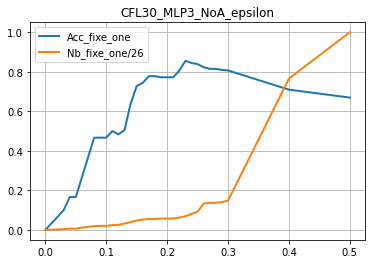

In [139]:
test_epsilon = []
epsilons = [0.01 * i for i in range(0,30,1)]+[0.01 * i for i in range(30,51,10)]
for e in epsilons:
    test_epsilon.append([e]+list(fixe_one_epsilon(predictions,y_hats,labels,e)))
header=["Epsilon", "Accuracy_fixe_one", "Number_fixe_one","Correct_One/Total_One"]
# print(tabulate(test_epsilon, headers=header))

with open("CSV/"+model_name+"_epsilon.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(test_epsilon)

fig, ax = plt.subplots()
values = np.array(test_epsilon).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"_epsilon")
plt.savefig("image/"+model_name+"_epsilon.png")
plt.grid()
plt.show()


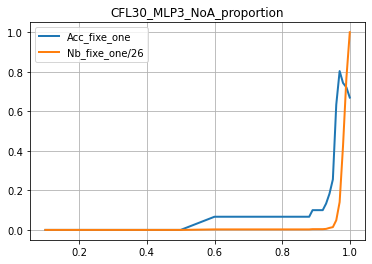

In [140]:
test_values = []
proportions = [0.1 * i for i in range(1,8)]+[0.01 * i for i in range(80,101)]
for p in proportions:
    test_values.append([p]+list(fixe_proportionally(predictions,labels,y_hats,is_corrects,proportion = p)))
header=["Proportion", "Accuracy_fixe_one", "Number_fixe_one","Accuracy_fixe_zero", "Number_fixe_zero"] 
# print(tabulate(test_values, headers=header))

with open("CSV/"+model_name+"_proportion.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(test_values)

fig, ax = plt.subplots()
values = np.array(test_values).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"_proportion")
plt.savefig("image/"+model_name+"_prop.png")
plt.grid()
plt.show()